In [17]:
import numpy as np
import cv2
output = np.load('./outheatmap.npz', allow_pickle=True)

data_path = str(output['data_path'])
if 'color' in data_path.split('/')[-1]:
    x_values = output['color']
elif 'rotation' in data_path.split('/')[-1]:
    x_values = output['rotation']
elif 'roundedness' in data_path.split('/')[-1]:
    x_values = output['roundedness']
x_values = x_values[:100]

In [18]:
from torch.nn.functional import mse_loss, softmax
import torch
heatmaps = torch.tensor(output['heatmaps'])

In [19]:
# def softmax(values):
#     return torch.exp(values) / torch.sum(torch.exp(values))

def minmax(values):
    return (values -values.min()) / ((values.max() - values.min())+10e-12)

In [20]:
from scipy.stats import wasserstein_distance
# metric = mse_loss
metric = wasserstein_distance
from functools import partial
# transform = partial(softmax, dim=0)
transform = minmax

In [21]:
changes = np.zeros(len(heatmaps)-1)
changes_original = np.zeros(len(output['heatmaps'])-1)
# x_values = output['angles']
with torch.no_grad():
    for i in range(len(output['heatmaps'])-1): 
        adj_change = metric(
            transform(heatmaps[i+1, ...].flatten()), 
            transform(heatmaps[i, ...].flatten()))
        changes[i] = adj_change
        changes_original[i] = metric(transform(heatmaps[i+1, ...].flatten()), 
                                       transform(heatmaps[0, ...].flatten()))

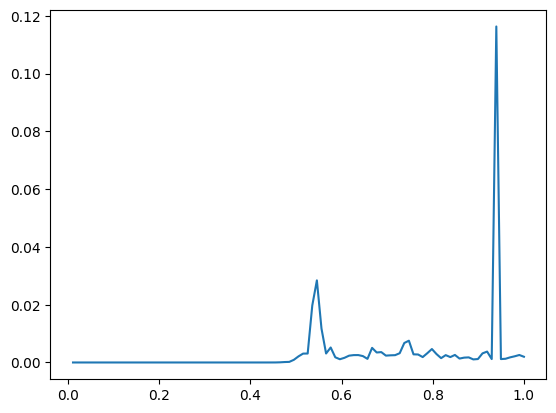

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.lineplot(x=x_values[1:], y=changes)
plt.show()

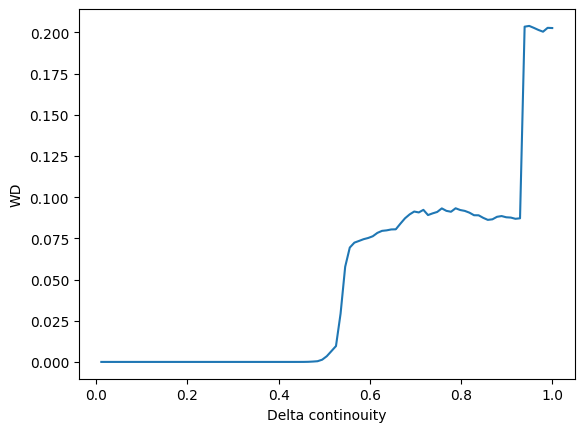

In [23]:
sns.lineplot(x=x_values[1:], y=changes_original)
plt.xlabel("Delta continouity")
plt.ylabel("WD")
plt.show()

In [24]:
from scipy.stats import kendalltau
res_kendall = kendalltau(x_values[1:][~np.isnan(changes_original)], changes_original[~np.isnan(changes_original)])
res_kendall.pvalue

1.1806494543481236e-37

In [25]:
res_kendall.statistic

0.8846806726625329

In [26]:
from scipy.stats import pearsonr
res_pearson = pearsonr(x_values[1:][~np.isnan(changes_original)], changes_original[~np.isnan(changes_original)])
res_pearson.pvalue

4.431541764684615e-31

In [27]:
res_pearson.statistic

0.8668557696780473

In [28]:
# sns.lineplot(x=x_values[1:][~np.isnan(changes_original)][16:32], y=changes_original[~np.isnan(changes_original)][16:32])

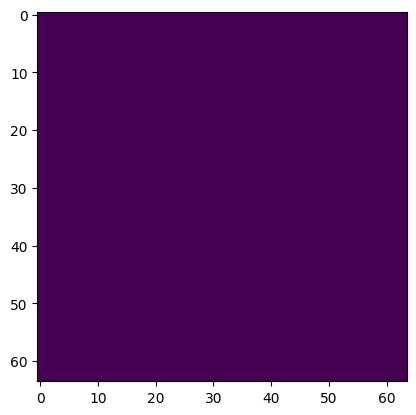

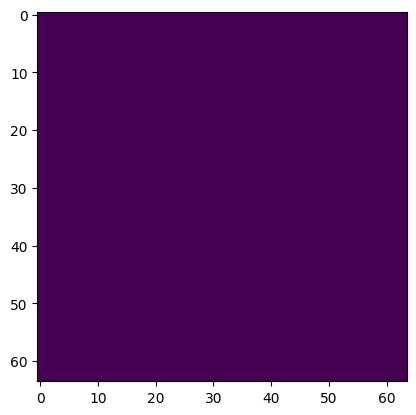

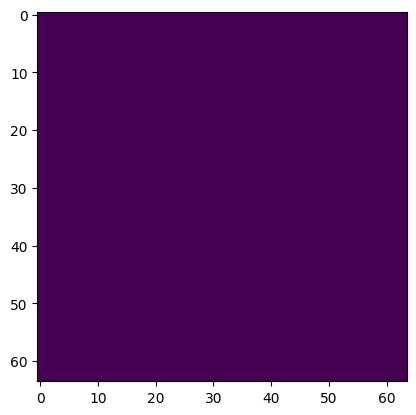

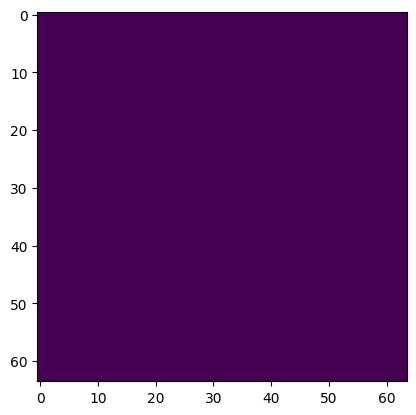

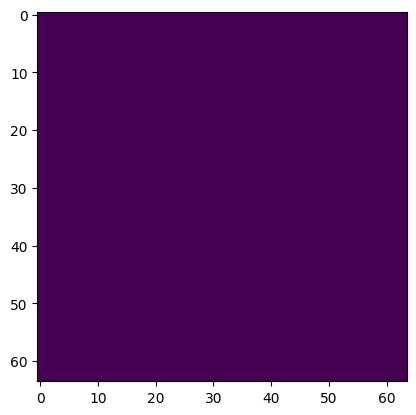

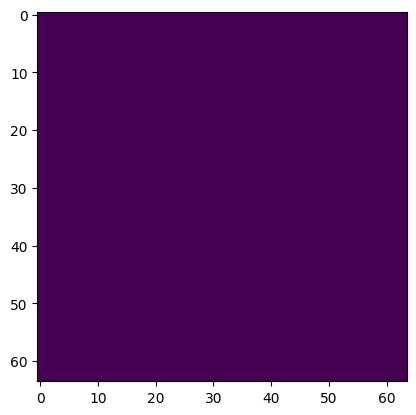

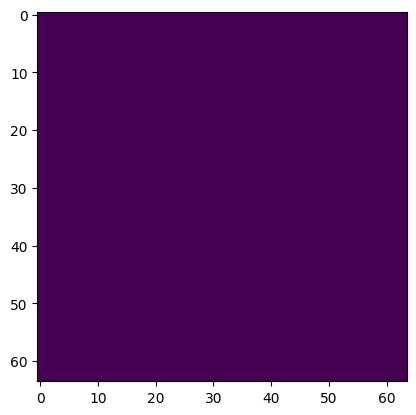

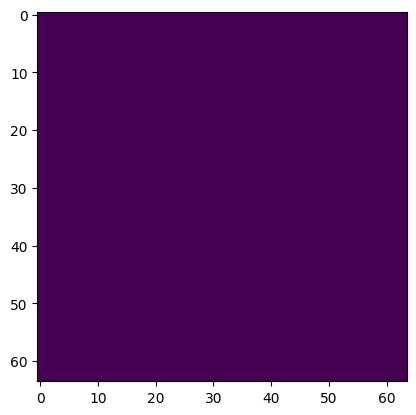

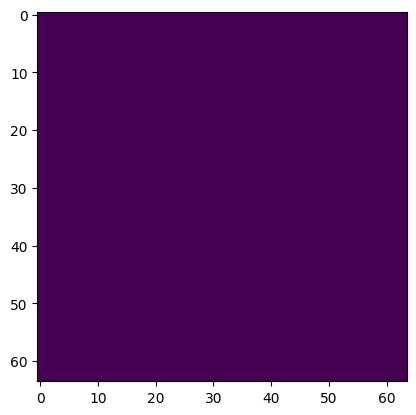

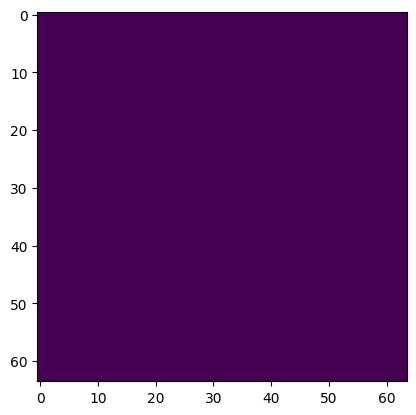

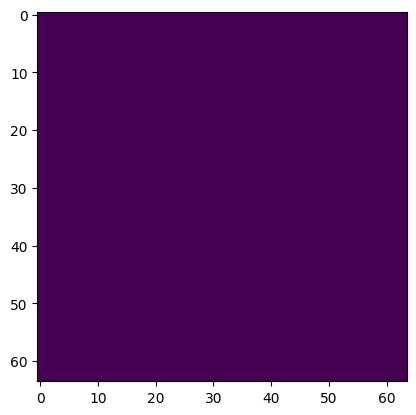

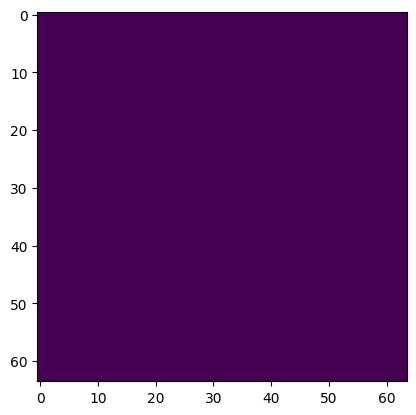

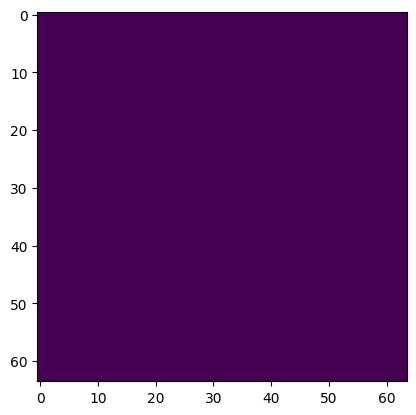

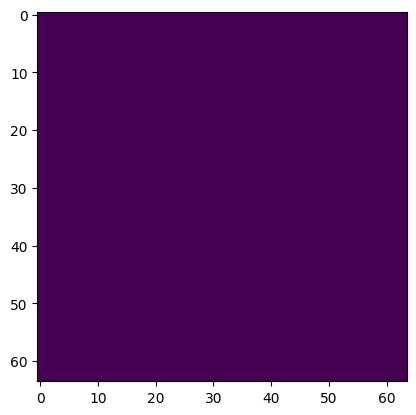

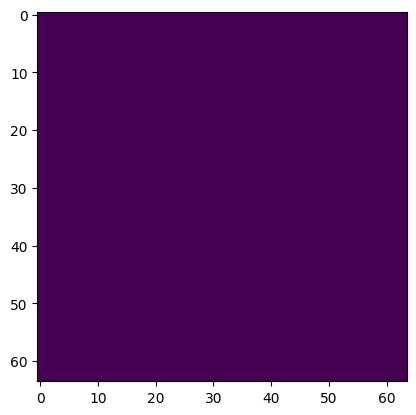

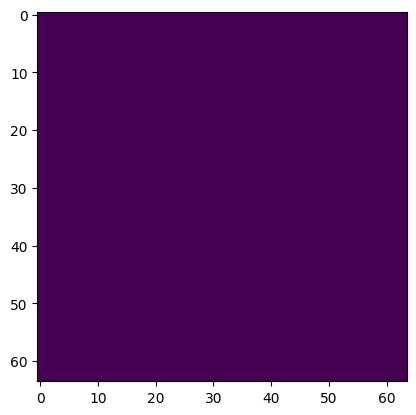

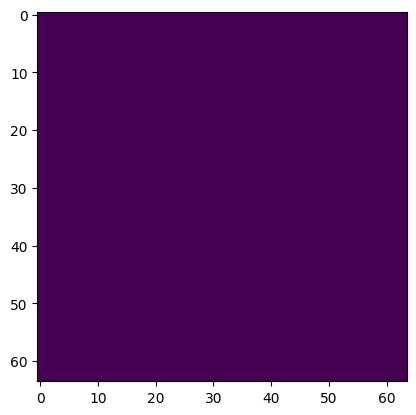

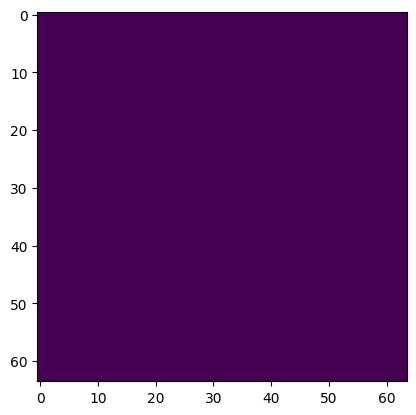

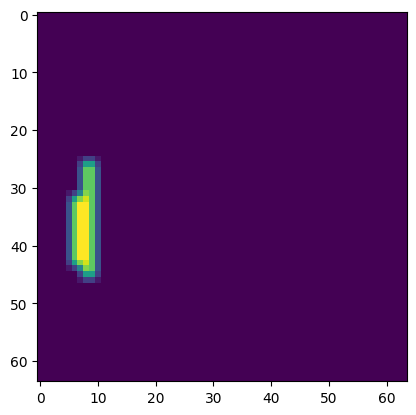

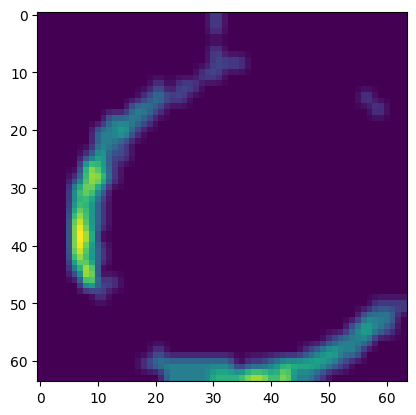

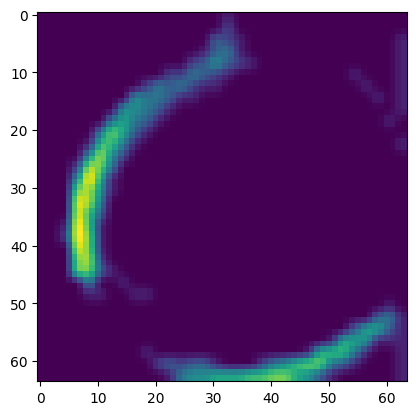

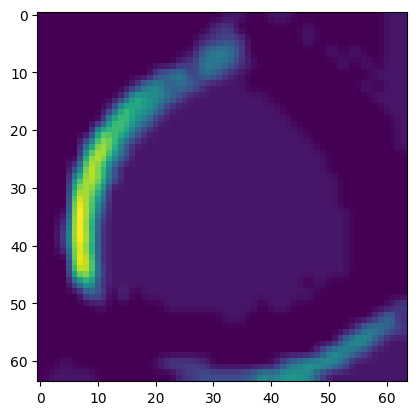

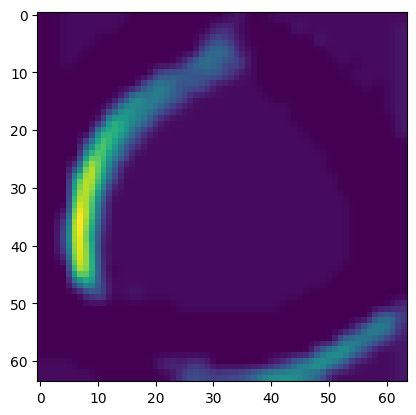

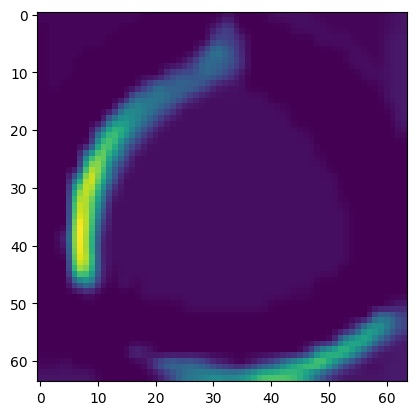

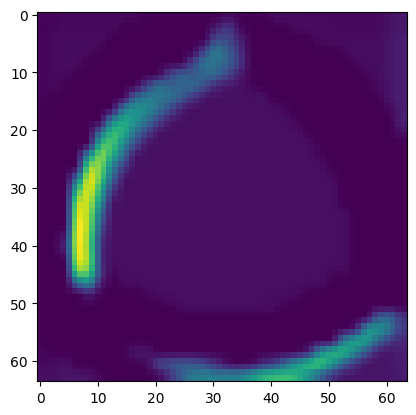

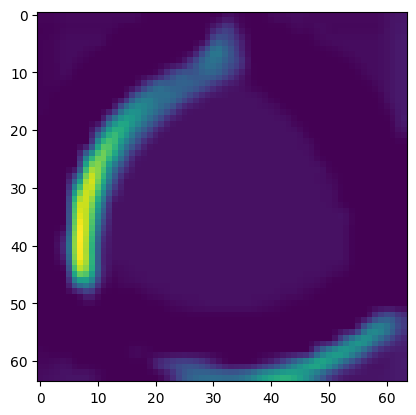

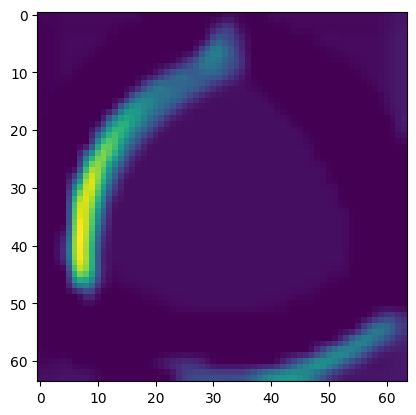

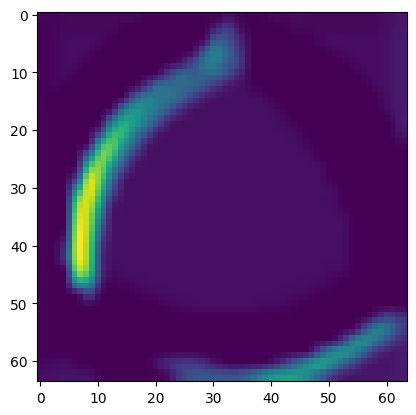

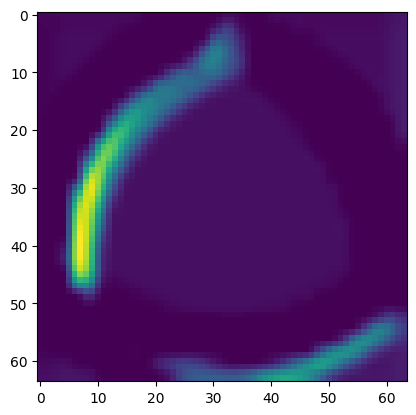

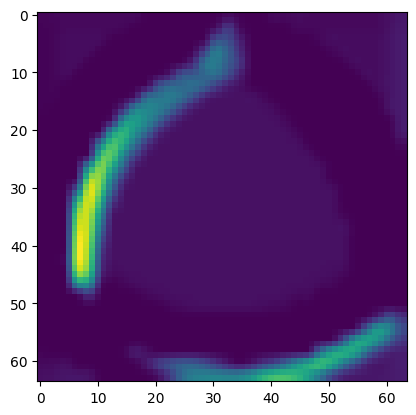

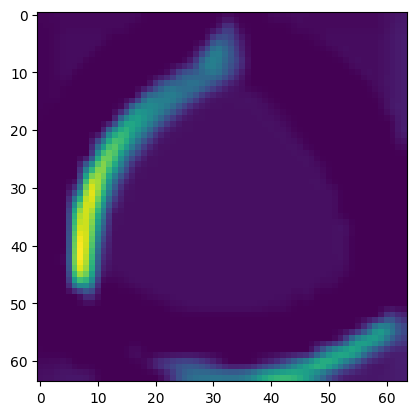

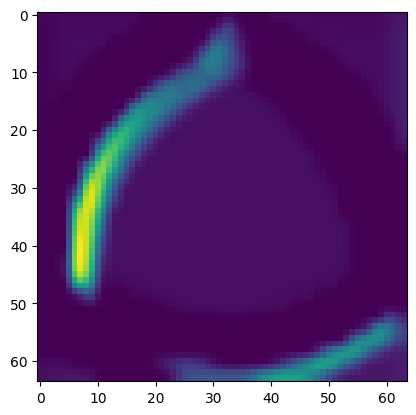

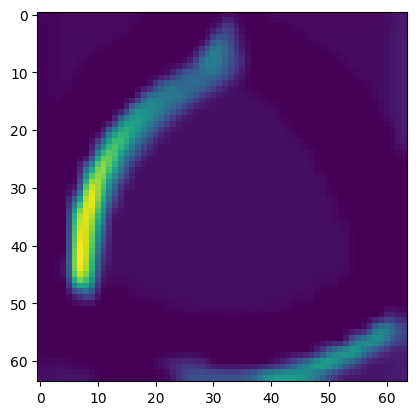

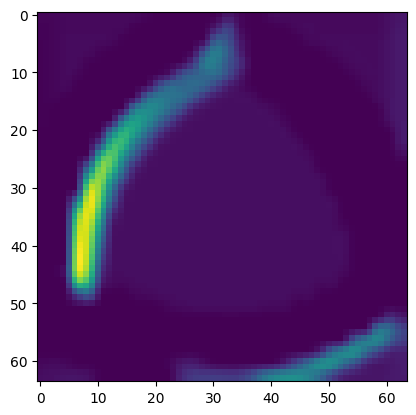

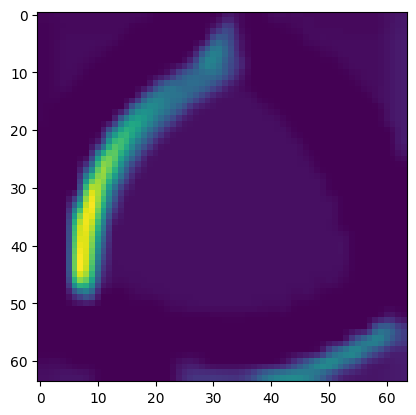

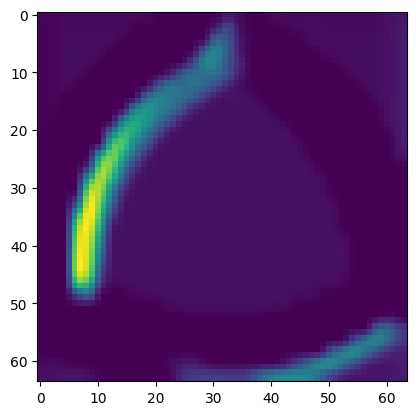

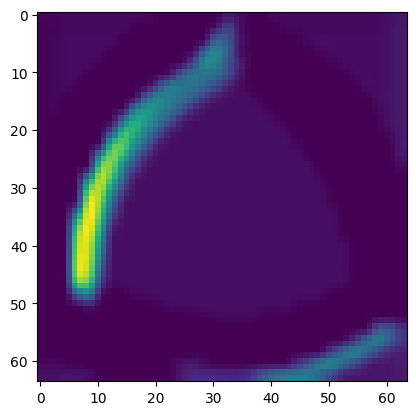

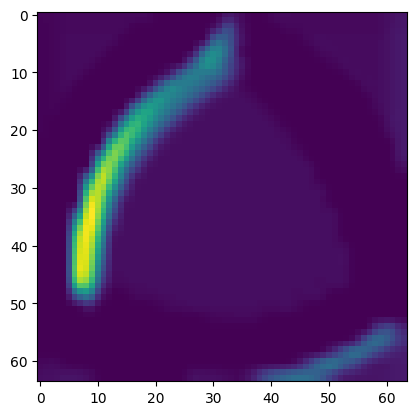

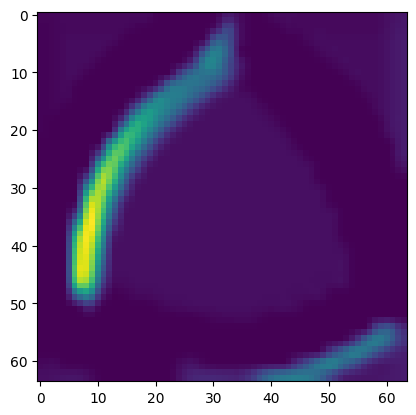

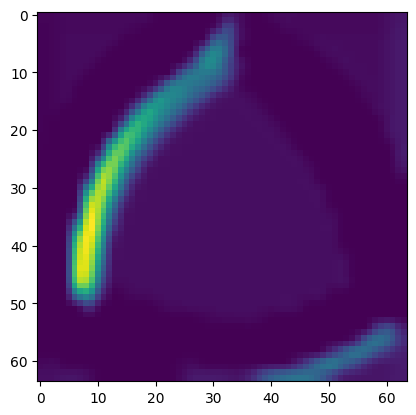

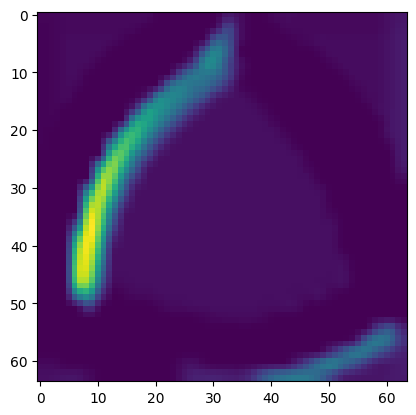

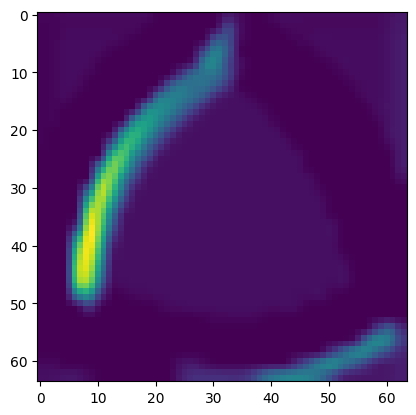

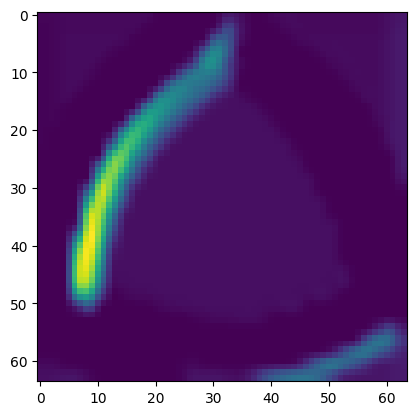

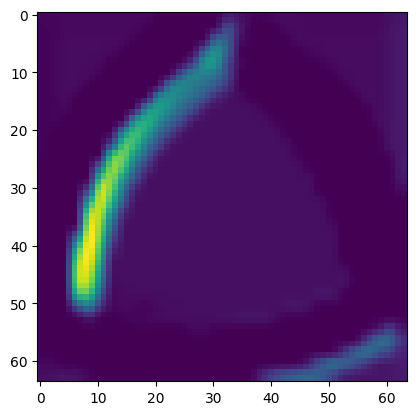

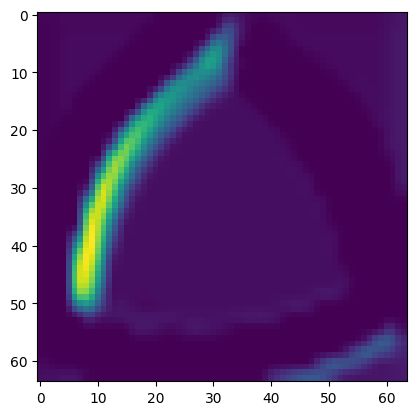

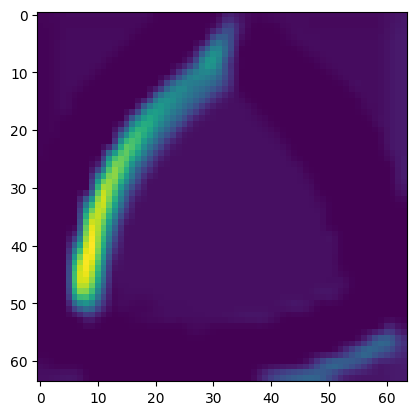

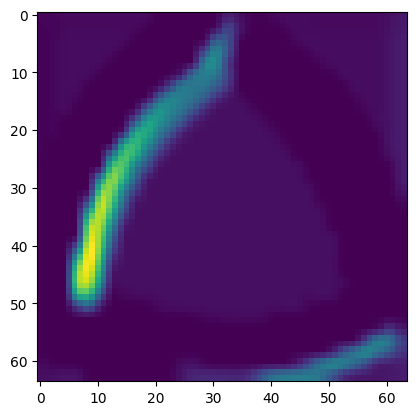

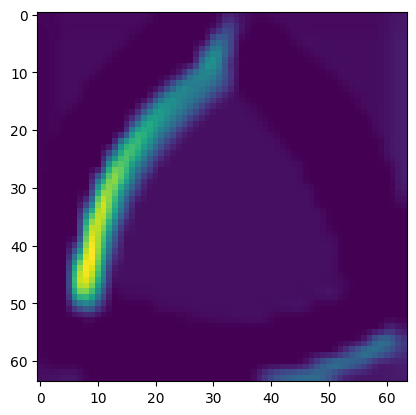

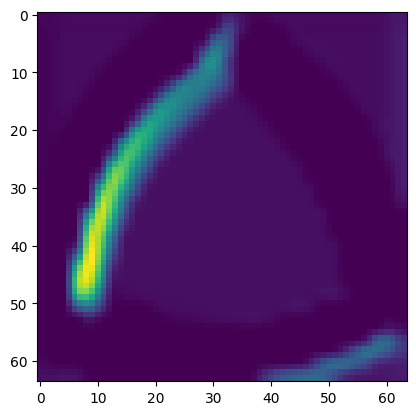

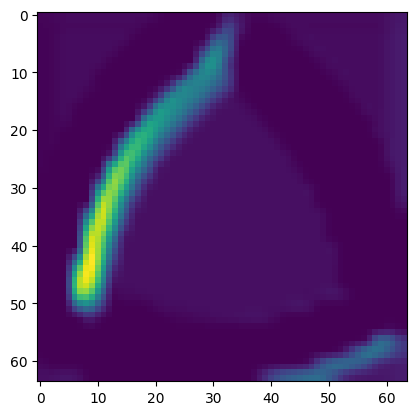

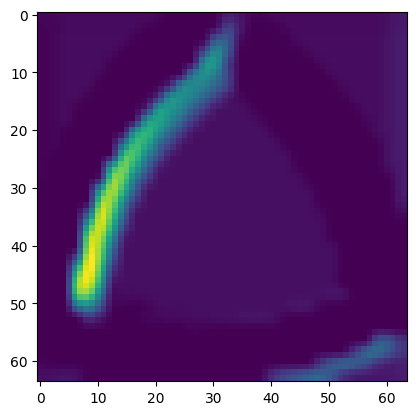

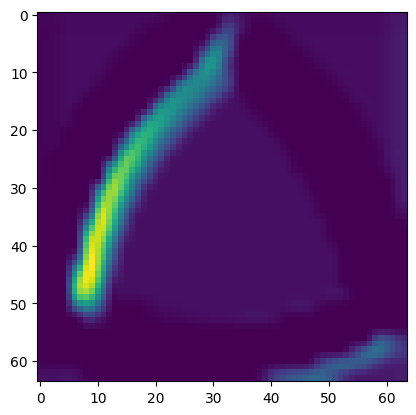

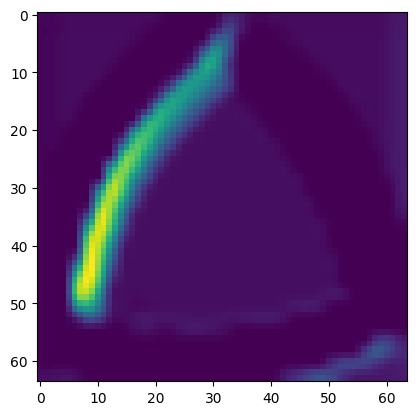

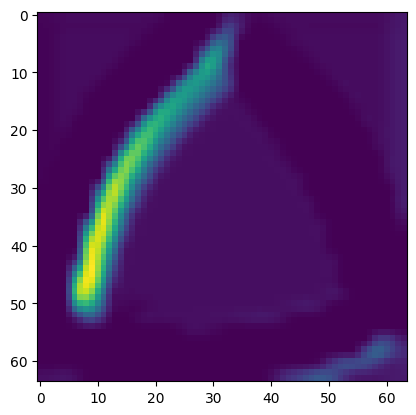

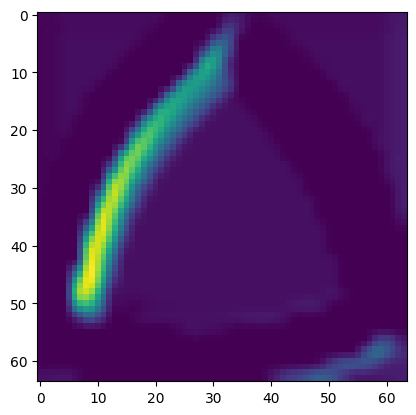

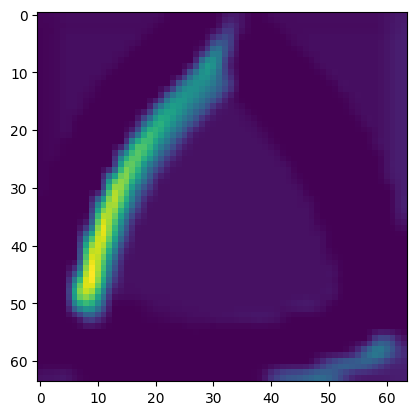

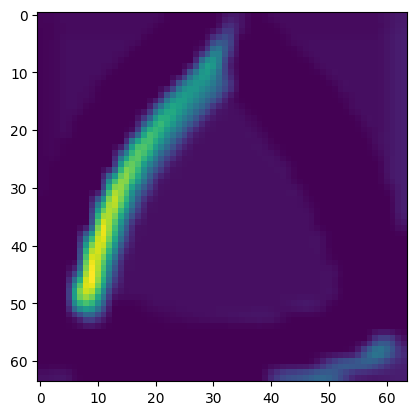

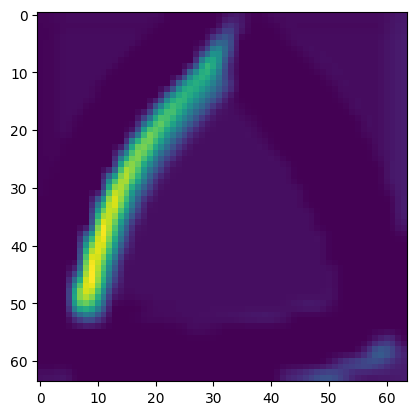

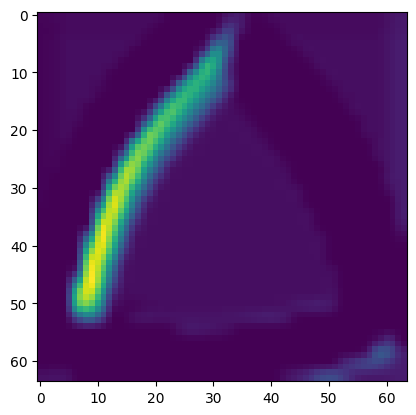

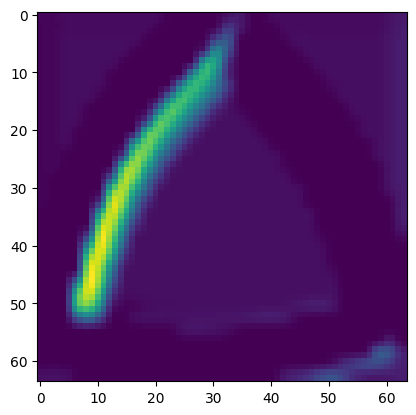

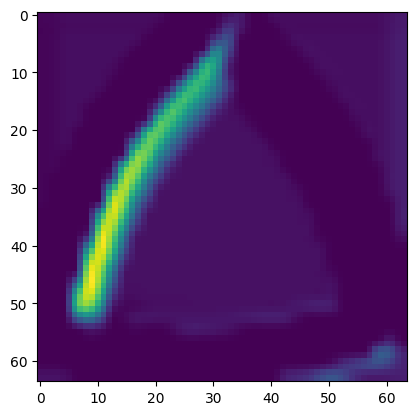

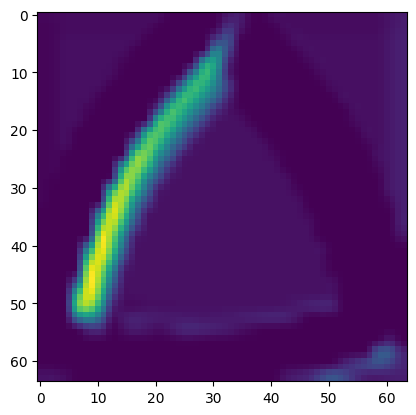

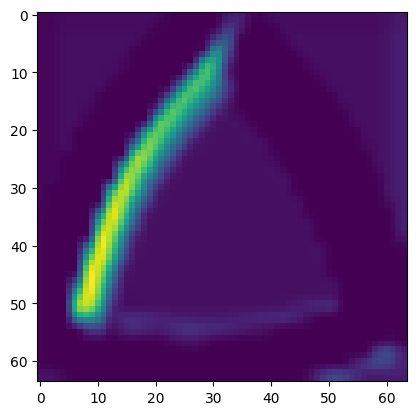

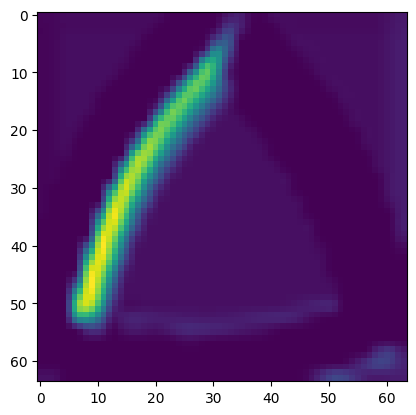

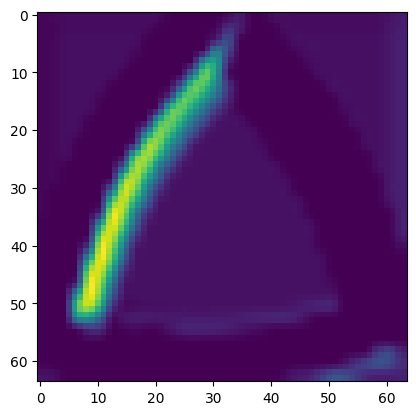

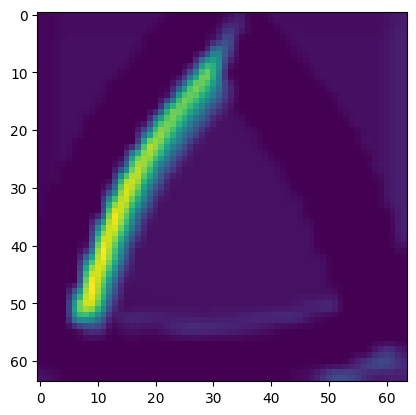

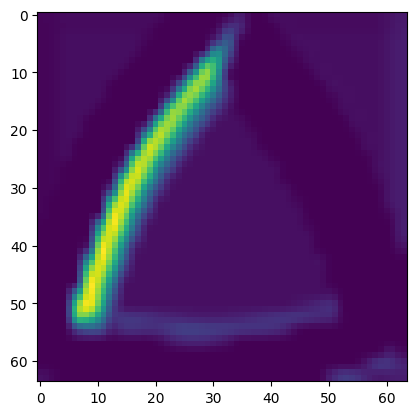

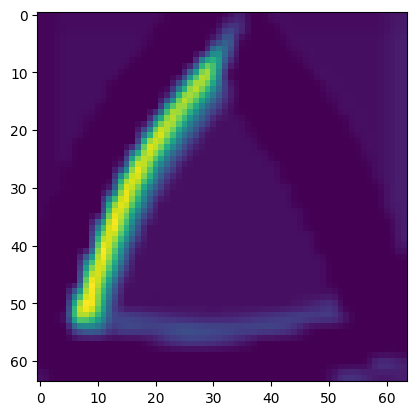

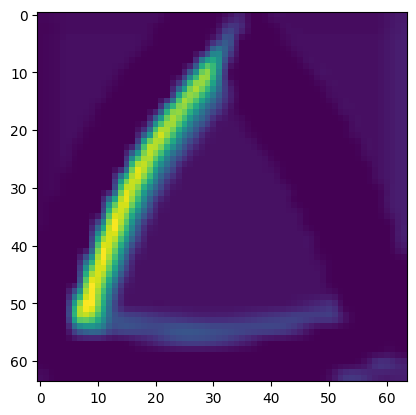

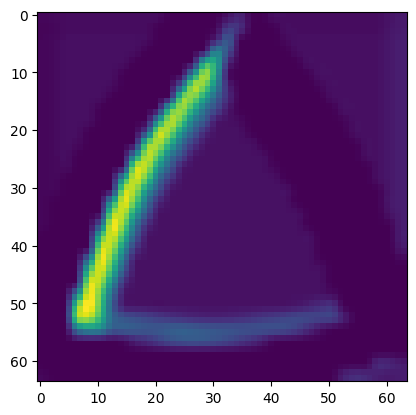

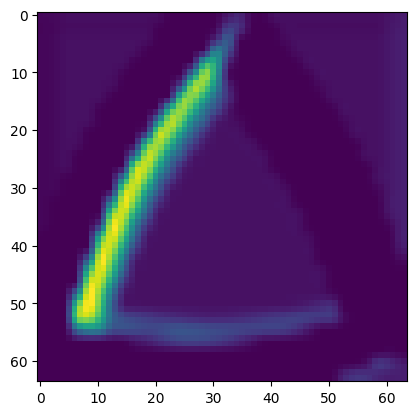

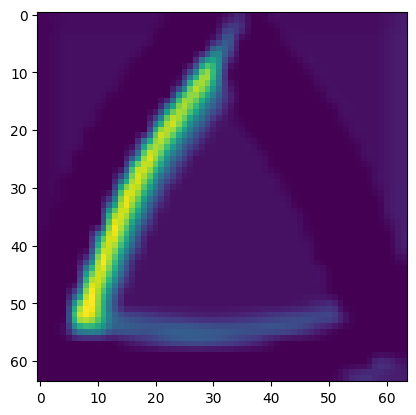

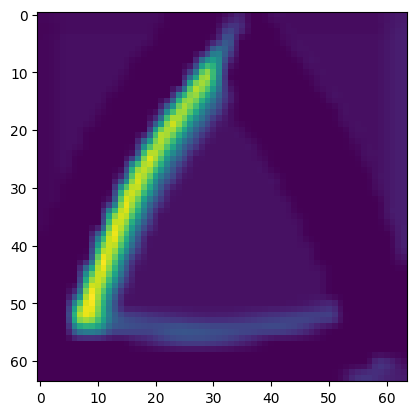

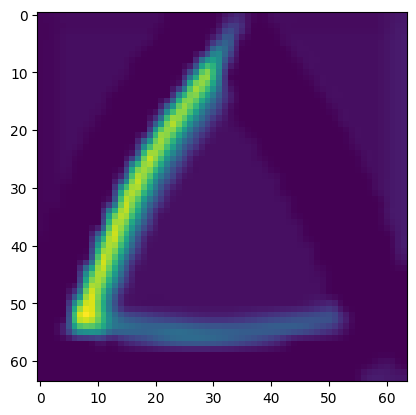

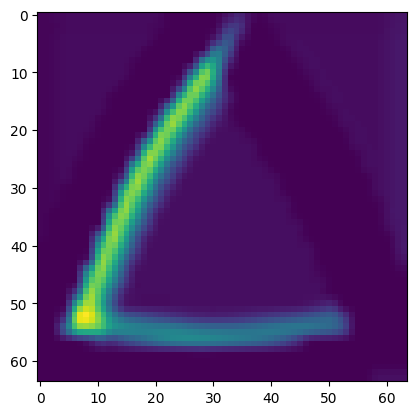

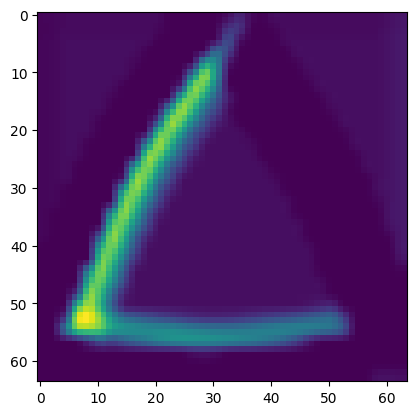

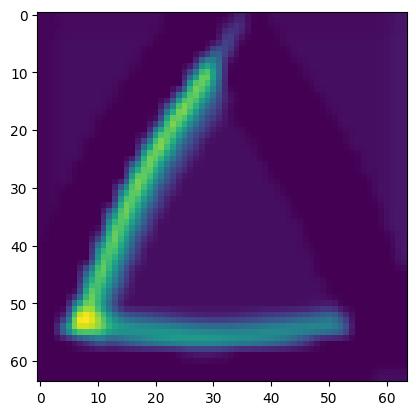

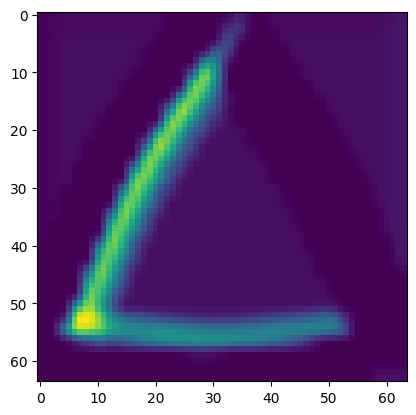

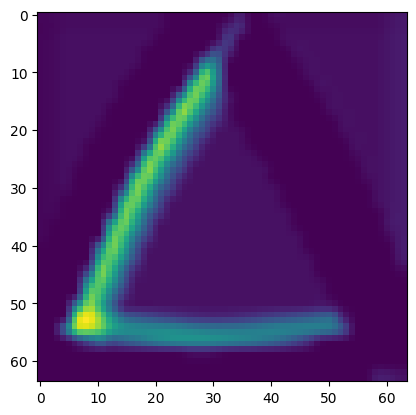

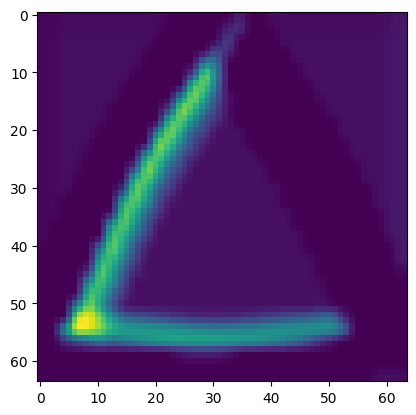

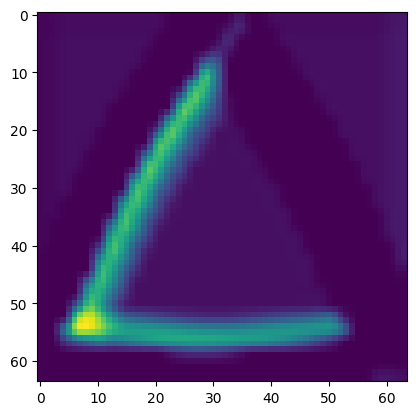

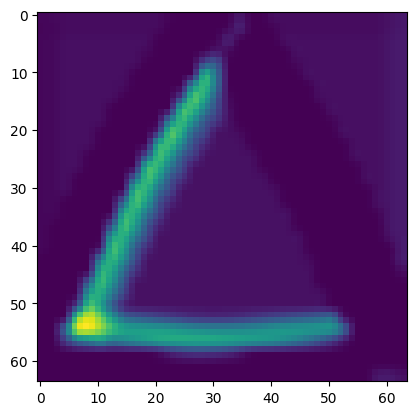

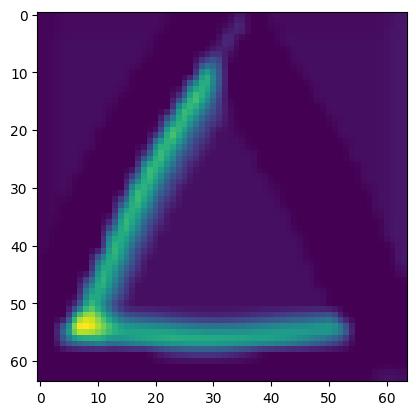

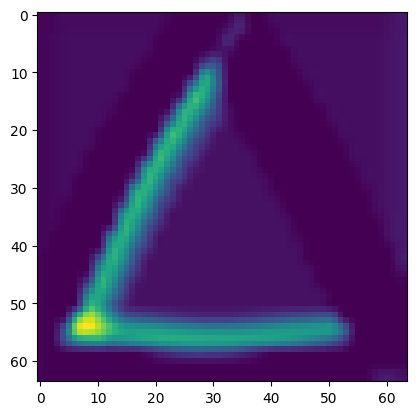

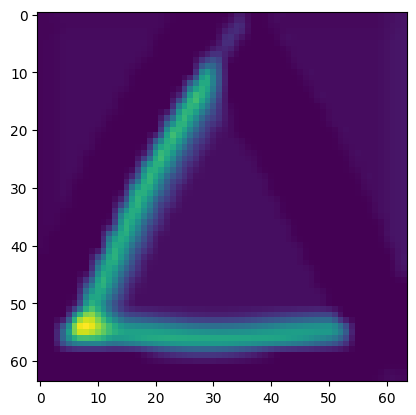

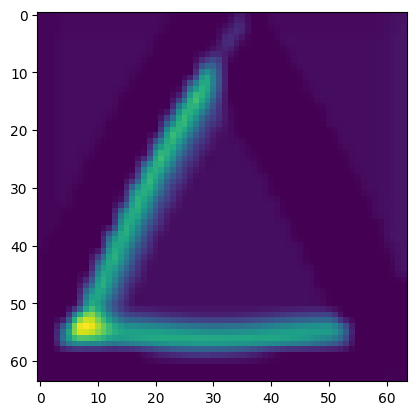

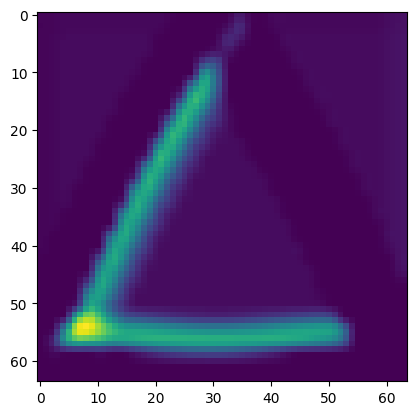

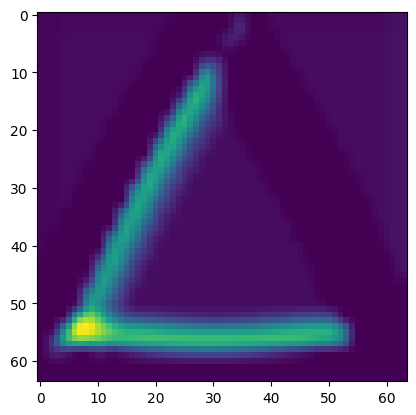

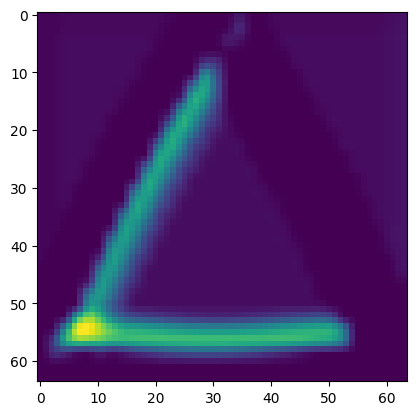

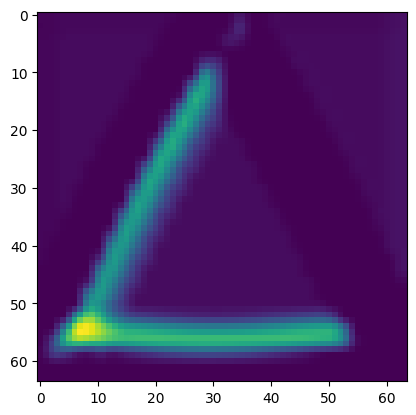

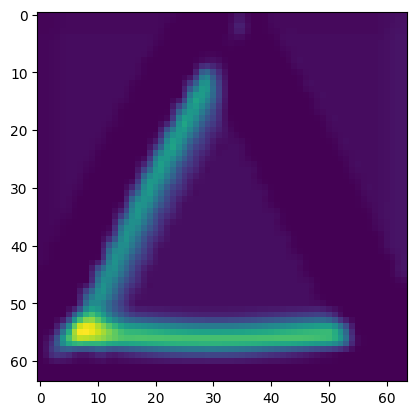

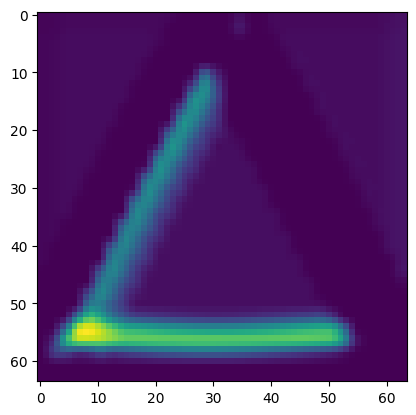

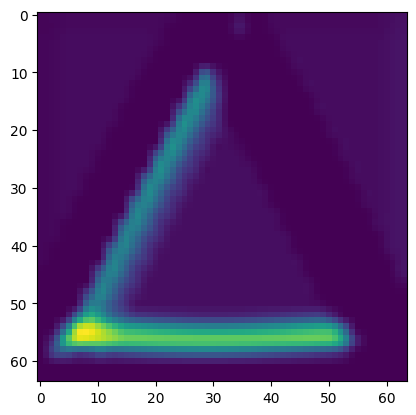

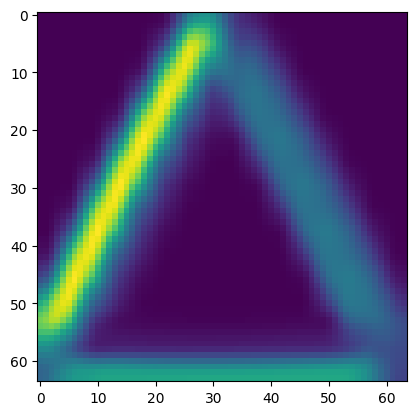

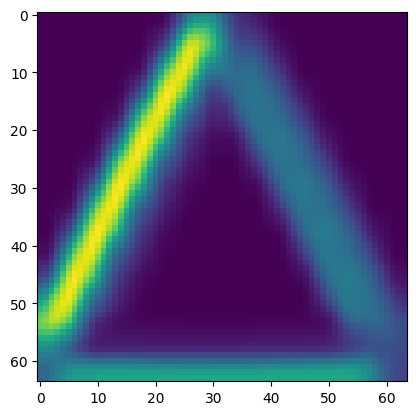

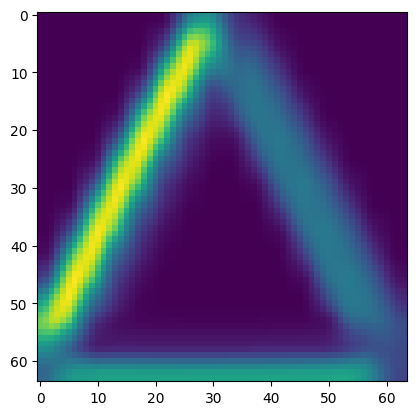

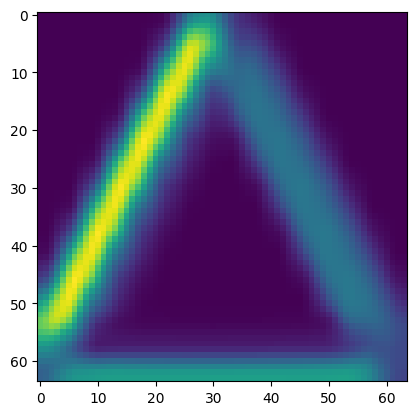

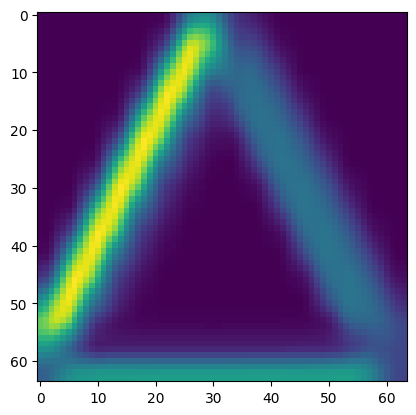

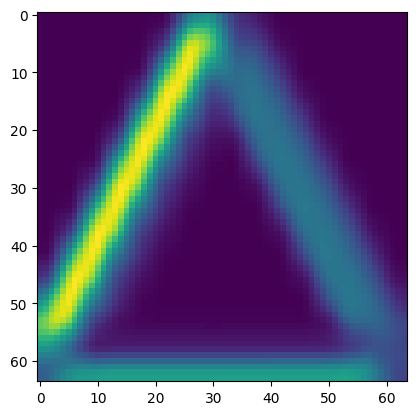

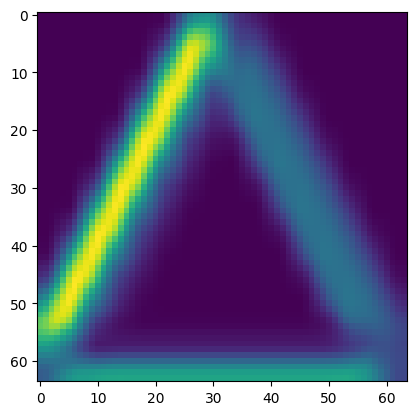

In [29]:
import matplotlib.pyplot as plt
for hm in output['heatmaps']:
    plt.imshow(hm)
    plt.show()
    plt.pause(0.0001)

In [30]:
# np.unique(hm)

In [31]:
# data_path = '/Users/qihuang/PhD/Projects/ICT_with_business/dianna-exploration/lorentz_workshop/dataset_roundedness.npz'
# np.load(data_path)['images'][0]

In [32]:
# data_path = '/Users/qihuang/PhD/Projects/ICT_with_business/dianna-exploration/example_data/dataset_preparation/geometric_shapes/test_colors.npz'
# np.load(data_path)['images']

<!-- # Confidence level changes vs (metrics between heatmaps) under Kendall Tau -->